In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.autograd import Variable
from typing import Dict, Any, Tuple, Union, NamedTuple,Optional,List
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(995)

In [2]:

lc = 1e-9
cc = 1e-5
# Physical constants
F = 96485 # Faraday constant [C/mol]
R = 8.3145 # Gas constant [J/(mol·K)]
T = 293 # Temperature [K]
k_B = 1.3806e-23 # Boltzmann constant [J/K]
eps0 = 8.85e-12 # Vacuum permittivity [F/m]
E_min = -1.0  # External applied potential [V] 
E_max = 1.8
# Diffusion coefficients [m²/s]
D_cv = 1.0e-21
D_av = 1.0e-21
D_h = 3.2823e-4

# Mobility coefficients [m²/(V·s)]
U_cv = -1.0562e-19
U_av = 7.9212e-20
U_h = 0.013 # mo_h from COMSOL

# Species charges
z_cv = -2.6667 # -8/3
z_av = 2
z_h = 1

# Permittivities [F/m]
epsilonf = 1.239e-10 # 14*eps0
eps_film = 1.239e-10 # Same as epsilonf
eps_Ddl = 1.77e-11 # 2*eps0
eps_dl = 6.947e-10 # 78.5*eps0
eps_sol = 6.947e-10 # Same as eps_dl

# Semiconductor properties
c_h0 = 4.1683e-4 # Intrinsic hole concentration [mol/m³]
c_e0 = 9.5329e-28 # Intrinsic electron concentration [mol/m³]
tau = 4.9817e-13 # Recombination time constant [s·mol/m³]
Nc = 166.06 # Conduction band density [mol/m³]
Nv = 1.6606e5 # Valence band density [mol/m³]
mu_e0 = 2.4033e-19 # Standard electron chemical potential [J]
Ec0 = 5.127e-19 # Conduction band edge [J]
Ev0 = 1.6022e-19 # Valence band edge [J]

# Solution properties
c_H = 0.01 # Proton concentration [mol/m³]
pH = 5

# Molar volume
Omega = 1.4e-5 # [m³/mol]
# Standard rate constants
k1_0 = 4.5e-8 # [m/s]
k2_0 = 3.6e-6 # [mol/(m²·s)]
k3_0 = 4.5e-9 # [mol/(m²·s)]
k4_0 = 2.25e-7 # [m/s]
k5_0 = 7.65e-9 # [mol/(m²·s)]
ktp_0 = 4.5e-8 # [-]
ko2_0 = 0.005 # [m/s]

# Charge transfer coefficients
alpha_cv = 0.3
alpha_av = 0.8
beta_cv = 0.1
beta_av = 0.8
alpha_tp = 0.2
a_par = 0.45 # For oxygen evolution
delta3 = 1.0

# Derived parameters [1/V]
a_cv = 23.764 # alpha_cv * 2 * F/(R*T)
a_av = 84.493 # alpha_av * 8/3 * F/(R*T)
b_cv = 7.9212 # beta_cv * 2 * F/(R*T)

# Geometric parameters [m]
d_Ddl = 2.0e-10 # Defect layer thickness
d_dl = 5.0e-10 # Double layer thickness
L_cell = 1.0e-6 # Cell length

# Equilibrium potentials
phi_O2_eq = 1.35 # [V]
phic = (R*T)/F
tc = (lc ** 2) / D_cv
L_initial = 1e-9
time_scale = 3600 

In [3]:
#Define networks

class Swish(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self,x):
        return torch.sigmoid(x)*x
    

class FFN(nn.Module):
    """
    Fully Connected Feed Forward Neural Network.
    Args:
        input_dim: Number of input features
        output_dim: Number of output features  
        hidden_layers: Number of hidden layers
        layer_size: Size of each hidden layer
        activation: Activation function name ('swish', 'swoosh', 'swash', 'squash_swish', 'relu', 'tanh')
        initialize_weights: Whether to apply Xavier initialization
    """
    def __init__(
        self,
        input_dim: int = 3,
        output_dim: int = 1,
        hidden_layers: int = 5,
        layer_size: int = 20,
        activation: str = "swish"
    ):
        super(FFN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.activation = Swish()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, layer_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(layer_size, layer_size)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(layer_size, output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        Args:
            x: Input tensor
        Returns:
            Output tensor
        """
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
        
        x = self.output_layer(x)
        return x


cv_net = FFN() #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
av_net = FFN()
u_net = FFN()
L_net = FFN(2,1) 
cv_net.to(device)
av_net.to(device)
u_net.to(device)
L_net.to(device)

total_model_parameters = list(cv_net.parameters()) + list(av_net.parameters()) + list(u_net.parameters()) + list(L_net.parameters()) 

In [4]:
#gradient and sampling utils

class GradientResults(NamedTuple):
    """
    Container for gradient computation results.

    Organizes all computed derivatives in a structured way for easy access.
    """
    # Network predictions
    phi: torch.Tensor  # Potential φ
    c_cv: torch.Tensor  # Cation vacancy concentration
    c_av: torch.Tensor  # Anion vacancy concentration

    # Time derivatives
    c_cv_t: torch.Tensor  # ∂c_cv/∂t
    c_av_t: torch.Tensor  # ∂c_av/∂t

    # First spatial derivatives
    phi_x: torch.Tensor  # ∂φ/∂x
    c_cv_x: torch.Tensor  # ∂c_cv/∂x
    c_av_x: torch.Tensor  # ∂c_av/∂x

    # Second spatial derivatives
    phi_xx: torch.Tensor  # ∂²φ/∂x²
    c_cv_xx: torch.Tensor  # ∂²c_cv/∂x²
    c_av_xx: torch.Tensor  # ∂²c_av/∂x²


def _grad(x,dx):
    """Take the derrivative of x w.r.t dx"""

    return torch.autograd.grad(x,dx,torch.ones_like(dx),create_graph=True,retain_graph=True)[0]

def compute_gradients(x, t, E):
    inputs_3d = torch.cat([x, t, E], dim=1)

    # Get network predictions
    phi = u_net(inputs_3d)
    c_cv_raw = cv_net(inputs_3d)
    c_av_raw = av_net(inputs_3d)


    # Networks predict concentrations directly
    c_cv = c_cv_raw
    c_av = c_av_raw


    # Direct derivatives
    c_cv_t = _grad(c_cv, t)
    c_av_t = _grad(c_av, t)

    # Compute first spatial derivatives
    phi_x = _grad(phi, x)

    c_cv_x = _grad(c_cv, x)
    c_av_x = _grad(c_av, x)

    # Compute second spatial derivatives
    phi_xx = _grad(phi_x, x)

    c_cv_xx = _grad(c_cv_x, x)
    c_av_xx = _grad(c_av_x, x)

    return GradientResults(
        phi=phi, c_cv=c_cv, c_av=c_av,
        c_cv_t=c_cv_t, c_av_t=c_av_t,
        phi_x=phi_x, c_cv_x=c_cv_x, c_av_x=c_av_x, 
        phi_xx=phi_xx, c_cv_xx=c_cv_xx, c_av_xx=c_av_xx
    )

def sample_interior_points(
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample interior collocation points for PDE residuals.

        Args:
            networks: NetworkManager instance

        Returns:
            Tuple of (x, t, E) tensors with requires_grad=True for x and t
        """
        batch_size = 2048

        # Sample time and applied potential
        t = torch.rand(batch_size, 1, device=device, requires_grad=True)
        single_E = (
                torch.rand(1, 1, device=device)
                * (E_max - E_min)
                + E_min
            )
        E = single_E.expand(batch_size, 1)

        # Get film thickness prediction
        L_pred = L_net(torch.cat([t, E], dim=1))

        # Sample spatial coordinates within [0, L(t,E)]
        x = torch.rand(batch_size, 1, device=device, requires_grad=True) * L_pred

        return x, t, E

def sample_boundary_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample boundary collocation points for boundary conditions.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for boundary points
    """
    batch_size = 2 * 1024

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True)
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    # Predict L for f/s boundary
    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)

    half_batch = batch_size // 2

    # Metal/film interface points (x = 0)
    x_mf = torch.zeros(half_batch, 1, device=device, requires_grad=True)
    t_mf = t[:half_batch]
    E_mf = E[:half_batch]

    # Film/solution interface points (x = L)
    x_fs = L_pred[half_batch:]
    t_fs = t[half_batch:]
    E_fs = E[half_batch:]

    # Combine boundary points
    x_boundary = torch.cat([x_mf, x_fs], dim=0)
    t_boundary = torch.cat([t_mf, t_fs], dim=0)
    E_boundary = torch.cat([E_mf, E_fs], dim=0)

    return x_boundary, t_boundary, E_boundary

def sample_initial_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample initial condition points at t = 0.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for initial condition points
    """
    batch_size = 1024

    # Initial time (t = 0)
    t = torch.zeros(batch_size, 1, device=device, requires_grad=True)
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    # Get initial film thickness
    L_initial_pred = L_net(torch.cat([t, E], dim=1))

    # Sample spatial coordinates
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True)
        * L_initial_pred
    )

    return x, t, E

def sample_film_physics_points() -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample points for film growth physics constraint.

    Returns:
        Tuple of (t, E) tensors for film physics constraint
    """
    batch_size = 2048

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True)
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    return t, E


In [5]:
def compute_rate_constants(t,E,single=False):
        """Compute the value of the rate constants for each reaction"""
        if single == True:
                # Predict the potential on the m/f (x=0) boundary
                x_mf = torch.zeros(1, 1, device=device)  # Single point
                inputs_mf = torch.cat([x_mf, t, E], dim=1)
                u_mf = u_net(inputs_mf)

                # k1 computation: k1 = k1_0 * exp(alpha_cv * 3F/(RT) * φ_mf)
                k1 = k1_0 * torch.exp(alpha_cv * 3 * (F / (R * T)) * u_mf)

                # k2 computation: k2 = k2_0 * exp(alpha_av * 2F/(RT) * φ_mf)
                k2 = k2_0 * torch.exp(a_cv * u_mf)

                #Predict L to use in calculation rate constants
                L_pred = L_net(torch.cat([t, E], dim=1))

                # Predict the potential on the f/s (x=L) boundary
                x_fs = L_pred  # This is already [1, 1]
                inputs_fs = torch.cat([x_fs, t, E], dim=1)
                u_fs = u_net(inputs_fs)

                # k3 computation: k3 = k3_0 * exp(beta_cv * (3-δ)F/(RT) * φ_fs)
                k3 = k3_0 * torch.exp(b_cv* u_fs)

                # k4 computation: chemical reaction, potential independent
                k4 = k4_0

                # k5 computation: k5 = k5_0 * (c_H+)^n, assuming n=1
                k5 = k5_0 * c_H

                ktp = 0.0 # Placeholder if ktp is not used


                # ko2 computation: ko2 = ko2_0 * exp(a_par * 2F/(RT) * (E - φ_O2_eq))
                ko2 = ko2_0 * torch.exp(a_par * 2 * F / (R * T) * (E - phi_O2_eq))

                return k1, k2, k3, k4, k5, ktp, ko2
        else:
                # Predict the potential on the m/f (x=0) boundary
                x_mf = torch.zeros(t.shape[0], 1, device=device)
                inputs_mf = torch.cat([x_mf, t, E], dim=1)
                u_mf = u_net(inputs_mf)

                # k1 computation: k1 = k1_0 * exp(alpha_cv * 3F/(RT) * φ_mf)
                k1 = k1_0 * torch.exp(alpha_cv * 3 * F / (R * T) * u_mf)

                # k2 computation: k2 = k2_0 * exp(alpha_av * 2F/(RT) * φ_mf)
                k2 = k2_0 * torch.exp(a_cv * u_mf)

                #Predict L to use in calculation rate constants
                L_pred = L_net(torch.cat([t, E], dim=1))

                # Predict the potential on the f/s (x=L) boundary
                x_fs = torch.ones(t.shape[0], 1, device=device) * L_pred
                inputs_fs = torch.cat([x_fs, t, E], dim=1)
                u_fs = u_net(inputs_fs)

                # k3 computation: k3 = k3_0 * exp(beta_cv * (3-δ)F/(RT) * φ_fs)
                k3 = k3_0 * torch.exp(b_cv* u_fs)

                # k4 computation: chemical reaction, potential independent
                k4 = k4_0

                # k5 computation: k5 = k5_0 * (c_H+)^n, assuming n=1
                k5 = k5_0 * c_H

                ktp = 0.0

                # ko2 computation: ko2 = ko2_0 * exp(a_par * 2F/(RT) * (E_ext - φ_O2_eq))
                ko2 = ko2_0 * torch.exp(a_par * 2 * F / (R * T) * (E - phi_O2_eq))

                return k1, k2, k3, k4, k5, ktp, ko2


def pde_residuals(x, t, E):
        """Compute the residuals due to every PDE"""
        GradientResults = compute_gradients(x,t, E)
        u_pred, cv_pred, av_pred, cv_t, av_t, u_x, cv_x, av_x,u_xx, cv_xx, av_xx = GradientResults

        # Convection-Diffusion Formulation of Nersnt-Planck
        cd_cv_residual = cv_t + (-D_cv * cv_xx) + (-U_cv * u_x * cv_x) - (U_cv * cv_pred * u_xx)

        cd_av_residual = av_t + (-D_av * av_xx) + (-U_av * u_x * av_x) - (U_av * av_pred * u_xx)

        # Poisson Residual Calculation

        poisson_residual = -epsilonf * u_xx - (F * (z_av * av_pred + z_cv * cv_pred))

        return cd_cv_residual, cd_av_residual, poisson_residual

def interior_loss(x,t,E):
        """Compute PDE residuals on interior points with individual tracking"""

        # Compute PDE residuals
        cd_cv_residual, cd_av_residual, poisson_residual = pde_residuals(x, t,E)

        # Calculate individual PDE losses
        cv_pde_loss = torch.mean(cd_cv_residual**2)

        av_pde_loss = torch.mean(cd_av_residual**2)

        poisson_pde_loss = torch.mean(poisson_residual**2)

        # Total interior loss
        total_interior_loss = cv_pde_loss + av_pde_loss +  poisson_pde_loss

        return total_interior_loss, cv_pde_loss, av_pde_loss, poisson_pde_loss


def boundary_loss(x,t,E):
        """Compute boundary losses with individual tracking"""
        batch_size = x.shape[0]
        half_batch = batch_size // 2

        # Split into metal/film and film/solution interfaces
        x_mf = x[:half_batch]
        x_fs = x[half_batch:]
        t_mf = t[:half_batch]
        t_fs = t[half_batch:]
        E_mf = E[:half_batch]
        E_fs = E[half_batch:]

        k1, k2, k3, k4, k5, ktp, ko2 = compute_rate_constants(t,E)
        # m/f interface conditions

        inputs_mf = torch.cat([x_mf, t_mf,E_mf], dim=1)
        # Predicting the potential at m/f interface
        u_pred_mf = u_net(inputs_mf)
        u_pred_mf_x = _grad(u_pred_mf, x_mf)    

        # cv at m/f conditions
        cv_pred_mf = cv_net(inputs_mf)
        cv_pred_mf_x = _grad(cv_pred_mf, x_mf)
        #Predict L to use in caclulating BC's
        L_pred_mf = L_net(torch.cat([t_mf, E_mf], dim=1))
        L_pred_mf_t = _grad(L_pred_mf, t_mf)

        q1 = k1_0* torch.exp(alpha_cv*(E_mf-u_pred_mf)) + U_cv*u_pred_mf_x  - L_pred_mf_t 
        cv_mf_loss = torch.mean((-D_cv*cv_pred_mf_x +q1*cv_pred_mf)**2)

        # av at m/f conditions 
        av_pred_mf = av_net(inputs_mf)
        av_pred_mf_x = _grad(av_pred_mf, x_mf)
        g2 = (4/3)*k2_0*torch.exp(alpha_av*(E_mf-u_pred_mf))
        q2 = -1*U_av*u_pred_mf_x - L_pred_mf_t 

        av_mf_loss = torch.mean((D_av*av_pred_mf_x -g2 +q2*av_pred_mf)**2)

        # potential at m/f conditions
        g3 = eps_Ddl* ((u_pred_mf-E_mf)/d_Ddl)

        u_mf_loss = torch.mean((-epsilonf*u_pred_mf_x -g3)**2)

        # f/s interface conditions
        inputs_fs = torch.cat([x_fs, t_fs,E_fs], dim=1)

        # Predicting the potential at f/s
        u_pred_fs = u_net(inputs_fs)
        u_pred_fs_x = _grad(u_pred_fs, x_fs)

        # cv at f/s conditions
        cv_pred_fs = cv_net(inputs_fs)
        cv_pred_fs_x = _grad(cv_pred_fs, x_fs)  

        g4 = -1*k3_0*torch.exp(beta_cv*u_pred_fs)
        q4 = -1*U_cv*u_pred_fs_x

        cv_fs_loss = torch.mean((-D_cv*cv_pred_fs_x -g4 + q4*cv_pred_fs)**2)

        # av at f/s conditions
        av_pred_fs = av_net(inputs_fs)
        av_pred_fs_x = _grad(av_pred_fs, x_fs)

        q5 = -1*(k4_0*torch.exp(alpha_av*u_pred_fs) + U_av*u_pred_fs_x)

        av_fs_loss = torch.mean((-D_av*av_pred_fs_x + q5*av_pred_fs)**2)

        # Potential at f/s loss
        r = -d_Ddl*(eps_film/eps_Ddl)*u_pred_fs_x - d_dl*(eps_film/eps_dl)*u_pred_fs_x
        u_fs_loss = torch.mean((u_pred_fs - r)**2)

        total_BC_loss = cv_mf_loss + av_mf_loss + u_mf_loss + cv_fs_loss + av_fs_loss + u_fs_loss 

        return total_BC_loss, cv_mf_loss, av_mf_loss, u_mf_loss, cv_fs_loss, av_fs_loss, u_fs_loss


def initial_loss(x,t,E):
        """Compute initial condition losses with individual tracking"""

        L_initial_pred = L_net(torch.cat([t, E], dim=1))
        inputs = torch.cat([x, t,E], dim=1)

        # Initial Conditions for film thickness
        L_initial_loss = torch.mean((L_initial_pred - L_initial)**2)

        # Cation Vacancy Initial Conditions
        cv_initial_pred = cv_net(inputs)
        cv_initial_t = _grad(cv_initial_pred, t)
        cv_initial_loss = torch.mean((cv_initial_pred)** 2) + torch.mean(cv_initial_t ** 2) 

        # Anion Vacancy Initial Conditions
        av_initial_pred = av_net(inputs)
        av_initial_t = _grad(av_initial_pred, t)
        av_initial_loss = torch.mean((av_initial_pred)** 2) + torch.mean(av_initial_t ** 2) 

        # Potential Initial Conditions
        u_initial_pred = u_net(inputs)
        u_initial_t = torch.autograd.grad(u_initial_pred, t, grad_outputs=torch.ones_like(u_initial_pred), retain_graph=True, create_graph=True)[0]
        poisson_initial_loss = torch.mean((u_initial_pred - (E-(1e7*x)))**2) + torch.mean(u_initial_t ** 2) #This is very stiff! 


        total_initial_loss = cv_initial_loss + av_initial_loss + poisson_initial_loss + L_initial_loss

        return total_initial_loss, cv_initial_loss, av_initial_loss, poisson_initial_loss, L_initial_loss



def film_loss(t,E):
        """Enforce dL/dt = Ω(k2 - k5)"""
        t = torch.rand(2048,1,device=device,requires_grad=True) * time_scale
        single_E = torch.rand(1,1,device=device)*(E_max - E_min) + E_min #Pick one random E in the range
        E = single_E.expand(2048,1) #Broadcast E value to same size as L values
        inputs = torch.cat([t,E],dim=1)
        L_pred = L_net(inputs)

        L_pred_t = _grad(L_pred, t)  # dL/dt
        # Get rate constants (using predicted L for f/s boundary)

        k1, k2, k3, k4, k5, ktp, ko2 = compute_rate_constants(t,E)

        dL_dt_physics = Omega * (k2 - k5)

        return torch.mean((L_pred_t - dL_dt_physics)**2)

In [6]:
def total_loss():
     #Investigate using one E for all the different samples, this might help a lot. Could do an easy fix here
     x_interior, t_interior, E_interior = sample_interior_points()
     x_boundary, t_boundary, E_boundary = sample_boundary_points()
     x_inital, t_initial, E_initial = sample_initial_points()
     t_film, E_film = sample_film_physics_points()

     total_interior_loss,cv_pde_loss,av_pde_loss,poisson_pde_loss = interior_loss(x_interior,t_interior,E_interior)
     total_boundary_loss, cv_mf_loss, av_mf_loss, u_mf_loss, cv_fs_loss, av_fs_loss, u_fs_loss  = boundary_loss(x_boundary,t_boundary,E_boundary)
     total_initial_loss, cv_initial_loss, av_initial_loss, poisson_initial_loss, L_initial_loss = initial_loss(x_inital,t_initial,E_initial)
     L_loss = 1/(6.022e23)*film_loss(t_film,E_film) #MacGyvered a scaling factor here to help with training

     interior_loss_dict = {
          "total_interior_loss": total_interior_loss.item(),
          "cv_pde_loss": cv_pde_loss.item(),
          "av_pde_loss": av_pde_loss.item(),
          "poisson_pde_loss": poisson_pde_loss.item()
     }
     boundary_loss_dict = {
          "total_boundary_loss": total_boundary_loss.item(),
          "cv_mf_loss": cv_mf_loss.item(),
          "av_mf_loss": av_mf_loss.item(),
          "u_mf_loss": u_mf_loss.item(),
          "cv_fs_loss": cv_fs_loss.item(),
          "av_fs_loss": av_fs_loss.item(),
          "u_fs_loss": u_fs_loss.item()
     }
     initial_loss_dict = {
          "total_initial_loss": total_initial_loss.item(),
          "cv_initial_loss": cv_initial_loss.item(),
          "av_initial_loss": av_initial_loss.item(),
          "poisson_initial_loss": poisson_initial_loss.item(),
          "L_initial_loss": L_initial_loss.item()
     }
     film_loss_dict = {
          "L_loss": L_loss.item()
     }
     
     total_loss = total_interior_loss + total_boundary_loss + total_initial_loss + L_loss
     return total_loss, interior_loss_dict, boundary_loss_dict, initial_loss_dict, film_loss_dict






In [7]:
lr = 1e-3
max_steps = 20000
optimizer=torch.optim.Adam([{'params': total_model_parameters}],lr=lr)

loss_list = []
interior_loss_list = []
boundary_loss_list = []
initial_loss_list = []
film_loss_list = []


for step in tqdm(range(max_steps),desc="Training Status"):
    cv_net.train()
    av_net.train()
    u_net.train()
    L_net.train()
    optimizer.zero_grad()

    total_loss_value, interior_loss_dict, boundary_loss_dict, initial_loss_dict, film_loss_dict = total_loss()

    total_loss_value.backward()
    optimizer.step()

    loss_list.append(total_loss_value.item())
    interior_loss_list.append(interior_loss_dict["total_interior_loss"])
    boundary_loss_list.append(boundary_loss_dict["total_boundary_loss"])
    initial_loss_list.append(initial_loss_dict["total_initial_loss"])
    film_loss_list.append(film_loss_dict["L_loss"])

    if step % 100 == 0:   
         tqdm.write(f"Total:{total_loss_value}, interior:{interior_loss_dict['total_interior_loss']}, boundary:{boundary_loss_dict['total_boundary_loss']}, initial:{initial_loss_dict['total_initial_loss']}, film:{film_loss_dict['L_loss']} at step:{step}")


Training Status:   0%|          | 0/20000 [00:00<?, ?it/s]

/home/mohidfarooqi/anaconda3/envs/physicsOxy/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Total:inf, interior:189840896.0, boundary:0.016595637425780296, initial:116862599168.0, film:inf at step:0
Total:41096220672.0, interior:12794.166015625, boundary:0.0016378334257751703, initial:1271104.375, film:41094938624.0 at step:100
Total:53736960000.0, interior:1066.10595703125, boundary:0.002332740230485797, initial:91859.5703125, film:53736865792.0 at step:200
Total:69628542976.0, interior:925.626953125, boundary:0.021963339298963547, initial:1809168.875, film:69626732544.0 at step:300
Total:46649573376.0, interior:551.122802734375, boundary:0.01695789396762848, initial:570569.5, film:46649004032.0 at step:400
Total:40277258240.0, interior:213.8214874267578, boundary:0.019410310313105583, initial:69993.1171875, film:40277188608.0 at step:500
Total:50333556736.0, interior:194.99710083007812, boundary:0.0010762817692011595, initial:1268.8876953125, film:50333556736.0 at step:600
Total:55766888448.0, interior:103.74859619140625, boundary:0.001917890040203929, initial:21127.6953125

In [8]:
def visualize_predictions(step: str = "final", save_path: Optional[str] = None) -> None:
    """
    Visualize network predictions across input ranges.
    Uses dimensional inputs matching pinnacle.ipynb approach.
    """
    print(f"📊 Generating prediction visualization for step {step}...")

    with torch.no_grad():
        # Define input ranges (all dimensional as in notebook)
        n_spatial = 50
        n_temporal = 50

        # Fix a representative dimensional potential for visualization
        E_fixed = torch.tensor([[0.8]], device=device)  # Dimensional E [V]

        # Dimensional time range 
        t_range = torch.linspace(0, time_scale, n_temporal, device=device)

        # Get final film thickness to set spatial range (networks expect dimensional inputs)
        t_final = torch.tensor([[time_scale]], device=device)
        L_final = L_net(torch.cat([t_final, E_fixed], dim=1)).item()
        x_range = torch.linspace(0, L_final, n_spatial, device=device)

        print(f"  📐 Time range: [0, {time_scale:.0f}] s")
        print(f"  📐 Spatial range: [0, {L_final:.2e}] m")
        print(f"  📐 Fixed potential: {E_fixed.item():.1f} V")

        # Create 2D grid for contour plots
        T_mesh, X_mesh = torch.meshgrid(t_range, x_range, indexing='ij')
        E_mesh = torch.full_like(T_mesh, E_fixed.item())

        # Stack inputs for 3D networks (dimensional)
        inputs_3d = torch.stack([
            X_mesh.flatten(),
            T_mesh.flatten(),
            E_mesh.flatten()
        ], dim=1)

        # Get network predictions (networks output dimensional values)
        phi_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
        c_cv_2d = cv_net(inputs_3d).reshape(n_temporal, n_spatial)
        c_av_2d = av_net(inputs_3d).reshape(n_temporal, n_spatial)

        # Film thickness evolution (dimensional)
        t_1d = t_range.unsqueeze(1)
        E_1d = torch.full_like(t_1d, E_fixed.item())
        L_inputs_1d = torch.cat([t_1d, E_1d], dim=1)
        L_1d = L_net(L_inputs_1d).squeeze()

        # Film growth at multiple potentials
        E_values_dimensional = [0.1, 0.4, 1.0, 1.6, 1.8]  # Dimensional voltages
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#8b61b3"]  # Distinct colors
        
        # Compute film growth for each potential
        L_multi = []
        for E_val in E_values_dimensional:
            E_tensor = torch.full_like(t_1d, E_val)
            L_inputs_multi = torch.cat([t_1d, E_tensor], dim=1)
            L_curve = L_net(L_inputs_multi).squeeze()
            L_multi.append(L_curve.cpu().numpy())

        # Convert to numpy for plotting
        t_np = t_range.cpu().numpy()
        x_np = x_range.cpu().numpy()
        T_np, X_np = np.meshgrid(t_np, x_np, indexing='ij')

        phi_np = phi_2d.cpu().numpy()
        c_cv_np = c_cv_2d.cpu().numpy()
        c_av_np = c_av_2d.cpu().numpy()
        L_np = L_1d.cpu().numpy()

        # Create plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Potential field
        im1 = axes[0, 0].contourf(X_np*1e9, T_np/3600, phi_np, levels=50, cmap='RdBu_r')
        axes[0, 0].set_xlabel('Position [nm]')
        axes[0, 0].set_ylabel('Time [hours]')
        axes[0, 0].set_title(f'Electric Potential φ(x,t) at E={E_fixed.item():.1f} V')
        plt.colorbar(im1, ax=axes[0, 0], label='Potential [V]')

        # 2. Cation vacancies
        im2 = axes[0, 1].contourf(X_np*1e9, T_np/3600, c_cv_np, levels=50, cmap='Reds')
        axes[0, 1].set_xlabel('Position [nm]')
        axes[0, 1].set_ylabel('Time [hours]')
        axes[0, 1].set_title(f'Cation Vacancy Concentration at E={E_fixed.item():.1f} V')
        plt.colorbar(im2, ax=axes[0, 1], label='Concentration [mol/m³]')

        # 3. Anion vacancies
        im3 = axes[0, 2].contourf(X_np*1e9, T_np/3600, c_av_np, levels=50, cmap='Blues')
        axes[0, 2].set_xlabel('Position [nm]')
        axes[0, 2].set_ylabel('Time [hours]')
        axes[0, 2].set_title(f'Anion Vacancy Concentration at E={E_fixed.item():.1f} V')
        plt.colorbar(im3, ax=axes[0, 2], label='Concentration [mol/m³]')

        # 4. Film Thickness Evolution at different potentials
        for i, (L_curve, E_val, color) in enumerate(zip(L_multi, E_values_dimensional, colors)):
            axes[1, 0].plot(t_np/3600, L_curve*1e9, color=color, linewidth=2.5, 
                           label=f'E = {E_val:.1f} V', alpha=0.8)
        axes[1, 0].set_xlabel('Time [hours]')
        axes[1, 0].set_ylabel('Film Thickness [nm]')
        axes[1, 0].set_title('Film Growth at Different Applied Potentials')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend(fontsize=10, framealpha=0.9)

        # 5. Film thickness for fixed potential
        axes[1, 1].plot(t_np/3600, L_np*1e9, 'k-', linewidth=3)
        axes[1, 1].set_xlabel('Time [hours]')
        axes[1, 1].set_ylabel('Film Thickness [nm]')
        axes[1, 1].set_title(f'Film Thickness Evolution at E={E_fixed.item():.1f} V')
        axes[1, 1].grid(True, alpha=0.3)

        # 6. Potential profile vs spatial position at fixed time
        x_sweep = torch.linspace(0, L_final, 50, device=device)
        t_mid = torch.full((50, 1), time_scale / 2, device=device)  # Middle time
        E_mid = torch.full((50, 1), E_fixed.item(), device=device)

        x_sweep_inputs = torch.cat([x_sweep.unsqueeze(1), t_mid, E_mid], dim=1)
        phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()

        axes[1, 2].plot(x_sweep.cpu().numpy()*1e9, phi_vs_x, 'r-', linewidth=2)
        axes[1, 2].set_xlabel('Position [nm]')
        axes[1, 2].set_ylabel('Electric Potential [V]')
        axes[1, 2].set_title(f'Potential Profile at t={time_scale/2/3600:.1f} h, E={E_fixed.item():.1f} V')
        axes[1, 2].grid(True, alpha=0.3)

        plt.suptitle(f'Network Predictions Overview - Step {step}', fontsize=16)
        plt.tight_layout()

        # Save plot
        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=500, bbox_inches='tight')
            print(f"  💾 Saved predictions plot to {save_path}")
        else:
            plt.show()

        plt.close()

        # Print dimensional statistics
        print(f"\n📈 Prediction Statistics (Step {step}) at E={E_fixed.item():.1f} V:")
        print("-" * 60)
        print(f"Potential φ:          {phi_np.min():.3f} to {phi_np.max():.3f} V (mean: {phi_np.mean():.3f})")
        print(f"Cation Vacancies:     {c_cv_np.min():.2e} to {c_cv_np.max():.2e} mol/m³")
        print(f"Anion Vacancies:      {c_av_np.min():.2e} to {c_av_np.max():.2e} mol/m³")
        print(f"Film Thickness:       {L_np.min()*1e9:.2f} to {L_np.max()*1e9:.2f} nm")
        print(f"Final thickness:      {L_np.max() * 1e9:.2f} nm")


def smooth_loss_data(data: List[float], window_length: int = 51) -> List[float]:
    """
    Apply moving average smoothing to loss data.
    """
    return moving_average(data, window_length)

def moving_average(data: List[float], window: int = 10) -> List[float]:
    """Simple moving average smoothing as fallback."""
    if window >= len(data):
        return data
    
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - window // 2)
        end = min(len(data), i + window // 2 + 1)
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

def plot_training_losses(loss_history: Dict[str, List[float]], 
                        save_path: Optional[str] = None,
                        smooth: bool = True,
                        smoothing_window: int = 50) -> None:
    """
    Create comprehensive plots of all loss components with optional smoothing.
    Adapted for the notebook's loss structure.
    """
    print("📉 Creating training loss plots...")
    if smooth:
        print(f"🔧 Applying smoothing with window size {smoothing_window}")
    
    # Helper function to plot with optional smoothing
    def plot_loss(ax, data, label, color=None, linewidth=2, alpha=0.8):
        if not data:
            return
            
        if smooth:
            # Plot raw data lightly in background
            ax.semilogy(data, color='lightgray', alpha=0.3, linewidth=0.5)
            # Plot smoothed data prominently
            smoothed_data = smooth_loss_data(data, smoothing_window)
            ax.semilogy(smoothed_data, label=f'{label}', 
                       color=color, linewidth=linewidth, alpha=alpha)
        else:
            ax.semilogy(data, label=label, color=color, linewidth=linewidth, alpha=alpha)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot main components
    plot_loss(ax, loss_history['total'], 'Total Loss', color='red', linewidth=2.5)
    plot_loss(ax, loss_history['interior'], 'Interior (PDE)', color='blue')
    plot_loss(ax, loss_history['boundary'], 'Boundary', color='green')  
    plot_loss(ax, loss_history['initial'], 'Initial', color='orange')
    plot_loss(ax, loss_history['film'], 'Film Physics', color='purple')
    
    ax.set_title('Training Loss Components', fontsize=16)
    ax.set_xlabel('Training Step', fontsize=12)
    ax.set_ylabel('Loss (log scale)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        suffix = "_smoothed" if smooth else ""
        final_path = save_path.replace('.png', f'{suffix}.png')
        plt.savefig(final_path, dpi=300, bbox_inches='tight')
        print(f"  💾 Saved loss plots to {final_path}")
    else:
        plt.show()
    
    plt.close()

📉 Creating training loss plots...
🔧 Applying smoothing with window size 50


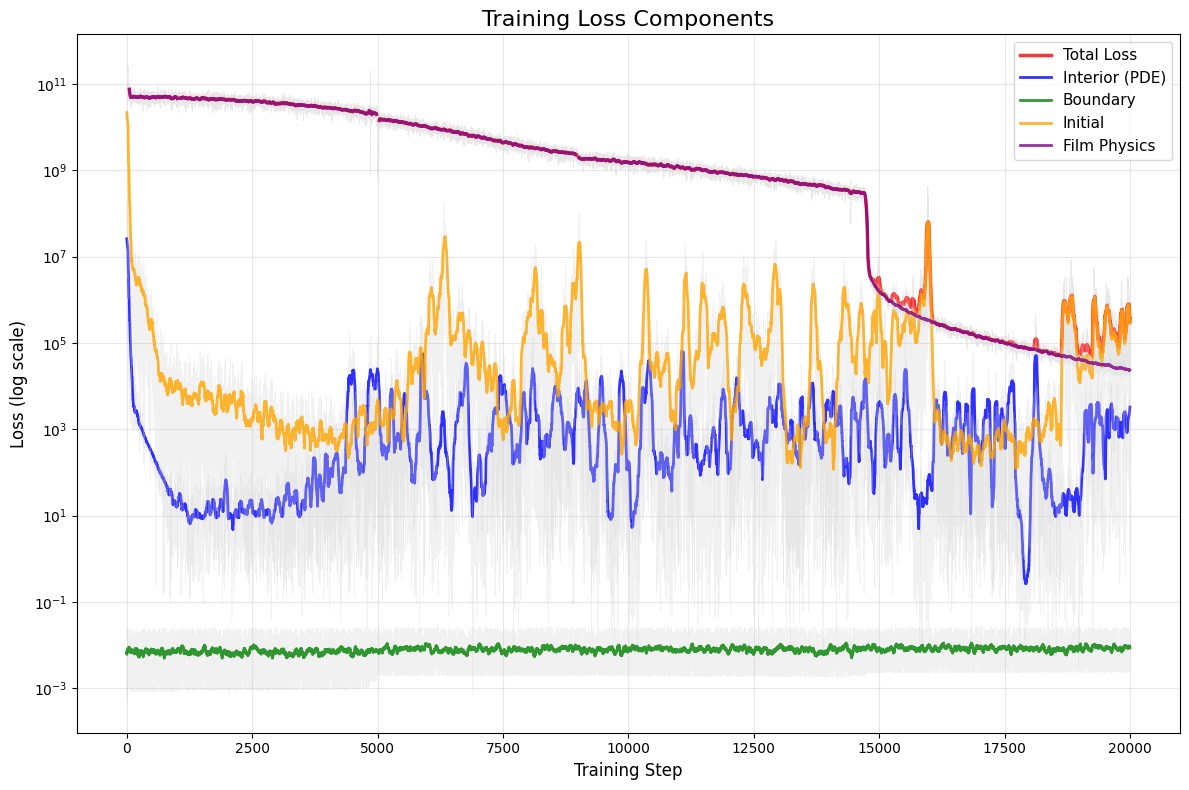

📊 Generating prediction visualization for step step_20000...
  📐 Time range: [0, 3600] s
  📐 Spatial range: [0, 1.35e+00] m
  📐 Fixed potential: 0.8 V


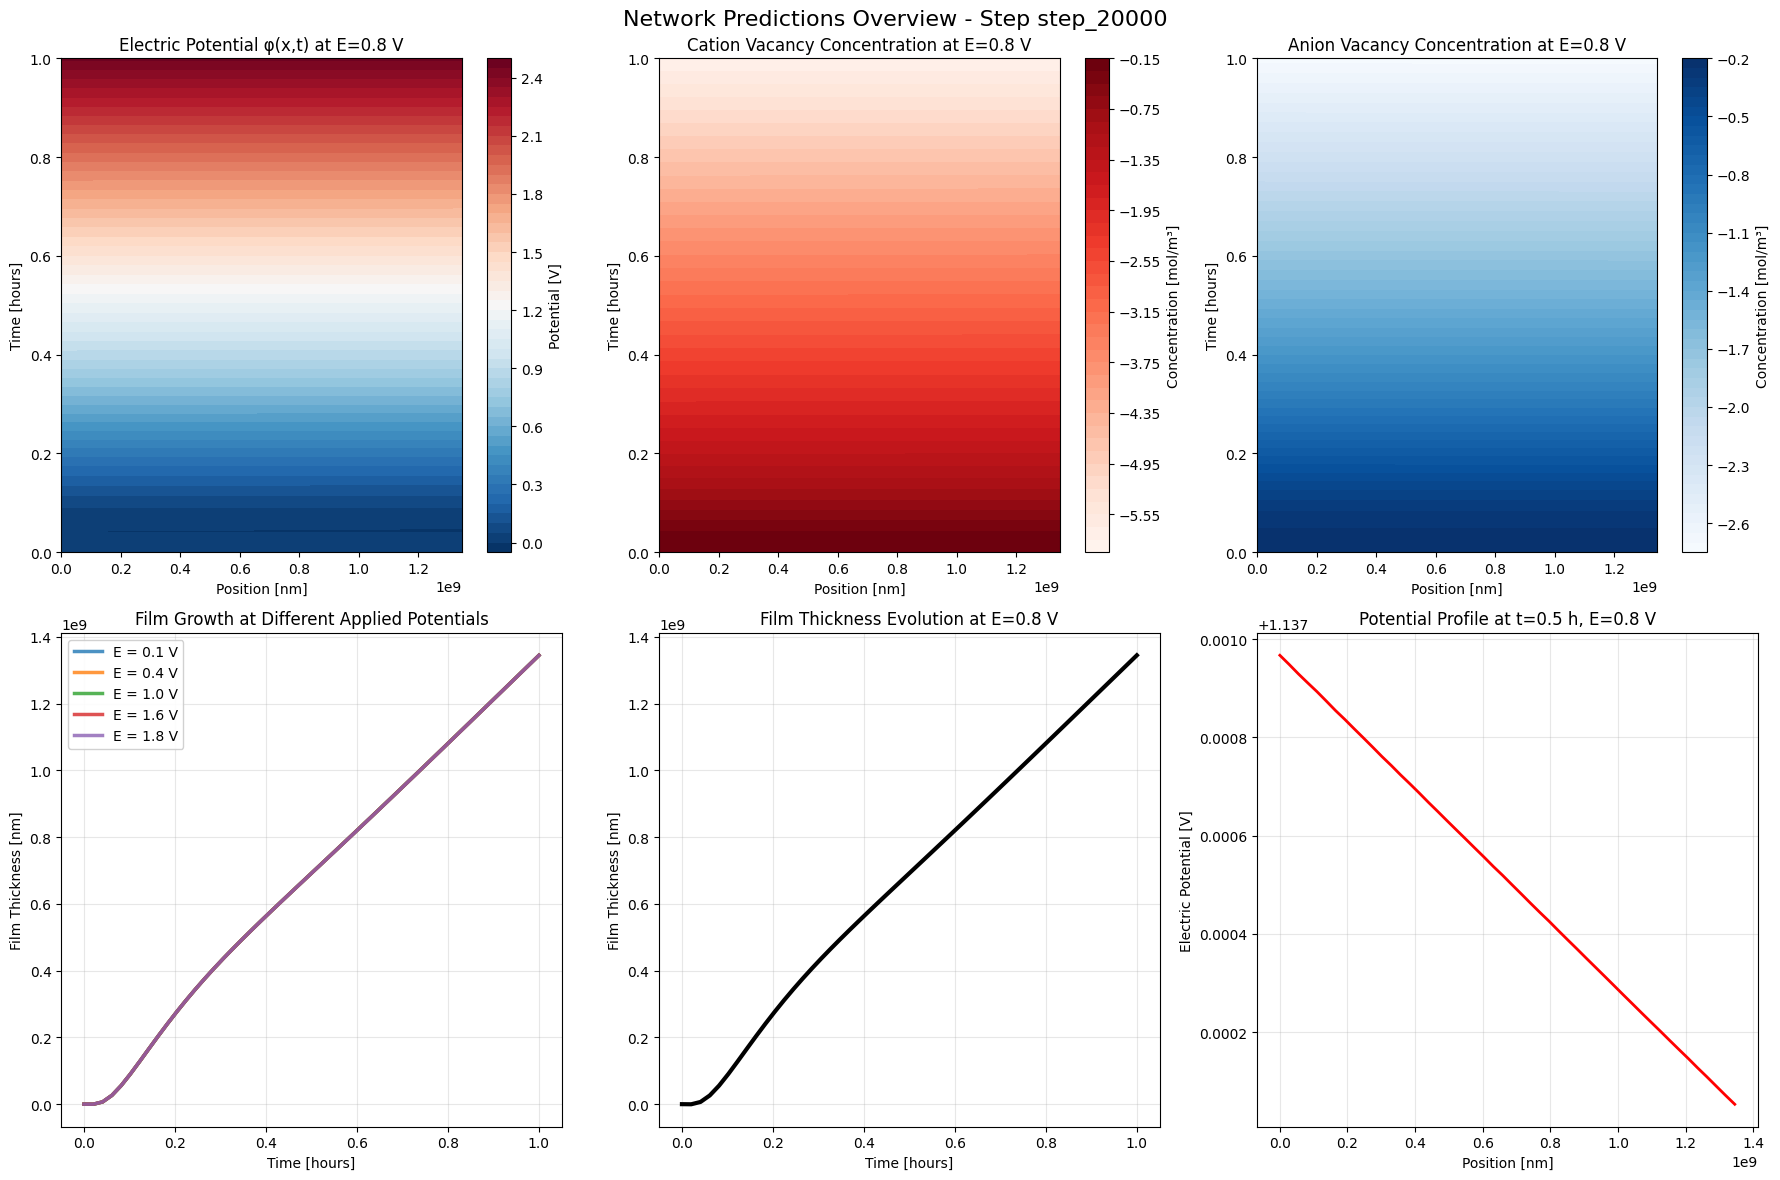


📈 Prediction Statistics (Step step_20000) at E=0.8 V:
------------------------------------------------------------
Potential φ:          -0.002 to 2.464 V (mean: 1.141)
Cation Vacancies:     -5.85e+00 to -1.72e-01 mol/m³
Anion Vacancies:      -2.73e+00 to -2.29e-01 mol/m³
Film Thickness:       -221148.14 to 1345077760.00 nm
Final thickness:      1345077760.00 nm


In [9]:
# Prepare loss history dictionary
loss_history = {
    'total': loss_list,
    'interior': interior_loss_list,
    'boundary': boundary_loss_list,
    'initial': initial_loss_list,
    'film': film_loss_list
}

# Plot training losses
plot_training_losses(
    loss_history=loss_history,
    save_path=None,
    smooth=True,
    smoothing_window=50
)

# Visualize network predictions
visualize_predictions(
    step=f"step_{len(loss_list)}"
    , save_path=None  # Set to a file path to save the plot
)